In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
#import utils


In [3]:
df = pd.read_csv('train.csv')
df_t = pd.read_csv('test.csv')


In [4]:
df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [5]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 6)) # create figure

plt.subplot2grid((2,3), (0,0))
df.Survived.value_counts(normalize=True).plot(kind='bar', alpha=0.5) # data that we want to plot
plt.title("Survived")

plt.subplot2grid((2,3), (0,1))
plt.scatter(df.Survived, df.Age, alpha=0.1)
plt.title("Age-Survived")

plt.subplot2grid((2,3), (0,2))
df.Pclass.value_counts(normalize=True).plot(kind='bar', alpha = 0.5)
plt.title("Classes")

plt.subplot2grid((2,3), (1,0), colspan=2)
for x in [1,2,3]:
    # find list of age where Pclass value is 1,2,3
    df.Age[df.Pclass == x].plot(kind="kde")
plt.title("Class-Age")
plt.legend(("1", "2", "3"))

# where did the passengers got on the ship (3 different locations)
plt.subplot2grid((2,3), (1,2))
df.Embarked.value_counts(normalize=True).plot(kind='bar', alpha=0.5)
plt.title("Embarked")

plt.show() # show figure

<Figure size 1800x600 with 5 Axes>



We can see thst 40% of people survived while around 60% dies

and bulk of both survived and died people were between 20-60 while some younger people
survived and older people died, but there isn't major age difference here.

Half of passengers where third class and around 25% were first and second class



In [7]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

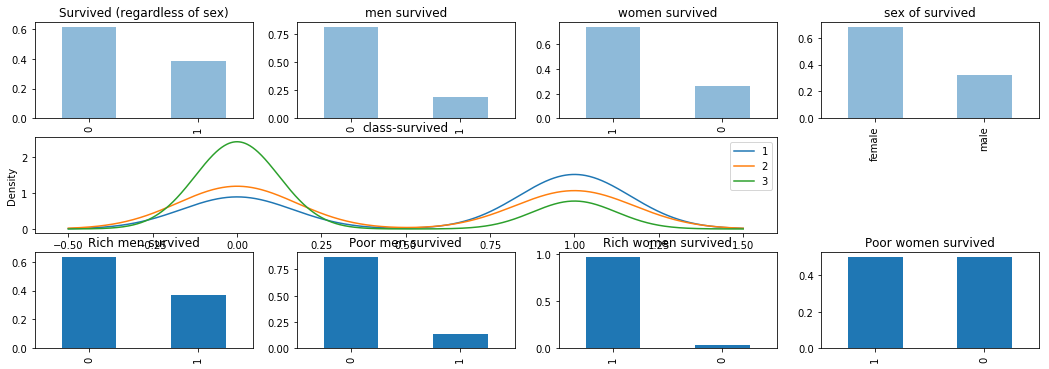

In [8]:
fig = plt.figure(figsize=(18,6))

plt.subplot2grid((3,4), (0,0))
df.Survived.value_counts(normalize=True).plot(kind='bar', alpha=0.5)
plt.title("Survived (regardless of sex)")

plt.subplot2grid((3,4), (0,1))
df.Survived[df.Sex=="male"].value_counts(normalize=True).plot(kind="bar", alpha=0.5)
plt.title("men survived")

plt.subplot2grid((3,4), (0,2))
df.Survived[df.Sex=="female"].value_counts(normalize=True).plot(kind="bar", alpha=0.5)
plt.title("women survived")

plt.subplot2grid((3,4), (0,3))
df.Sex[df.Survived==1].value_counts(normalize=True).plot(kind="bar", alpha=0.5)
plt.title("sex of survived")

plt.subplot2grid((3,4), (1,0), colspan=3)
for x in [1,2,3]:
    df.Survived[df.Pclass == x].plot(kind="kde")
plt.title("class-survived")
plt.legend(("1", "2", "3"))

plt.subplot2grid((3,4), (2,0))
df.Survived[(df.Sex =='male') & (df.Pclass == 1)].value_counts(normalize=True).plot(kind="bar")
plt.title("Rich men survived")

plt.subplot2grid((3,4), (2,1))
df.Survived[(df.Sex =='male') & (df.Pclass == 3)].value_counts(normalize=True).plot(kind="bar")
plt.title("Poor men survived")

plt.subplot2grid((3,4), (2,2))
df.Survived[(df.Sex =='female') & (df.Pclass == 1)].value_counts(normalize=True).plot(kind="bar")
plt.title("Rich women survived")

plt.subplot2grid((3,4), (2,3))
df.Survived[(df.Sex =='female') & (df.Pclass == 3)].value_counts(normalize=True).plot(kind="bar")
plt.title("Poor women survived")

plt.show()

We can see that while only 25% of men survived, for women the number is around 70%

Also while most of people in passenger class 3 didn't survive,

In [9]:
df_t.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [10]:
# clean data and fill empty columns
df["Fare"] = df["Fare"].fillna(df["Fare"].dropna().median())
df["Age"] = df["Age"].fillna(df["Age"].dropna().median())

# encode categorical data into one hot vectors
labelencoder_1 = LabelEncoder()
df['Sex'] = labelencoder_1.fit_transform(df['Sex'])
# label data : 0,1,2,..
labelencoder_2 = LabelEncoder()
df['Embarked'] = labelencoder_2.fit_transform(df['Embarked'].astype(str))
# slect X, Y
Y = df.iloc[:,1]
X = df.iloc[:, [2,4,5,6,7,9,11]]
# encode the data
onehotencoder = OneHotEncoder(categorical_features=[-1])
X = onehotencoder.fit_transform(X).toarray()

/home/veeru/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/veeru/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


In [11]:
# scale the data
sc = StandardScaler()
X = sc.fit_transform(X)

**Logistic Regression**


In [12]:
classifier = linear_model.LogisticRegression()
classifier.fit(X, Y)

/home/veeru/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [13]:
classifier.score(X, Y)

0.797979797979798

In [14]:
print(classifier.coef_)
# pd.DataFrame(classifier.coef_, columns=['Coeff'])

[[ 0.0720988   0.03277411 -0.10183244  0.17268122 -0.89986045 -1.28402927
  -0.50001868 -0.34912776 -0.07031458  0.1013196 ]]


Positive means when we increase the perticular column value then there is more chace of being survived

Negative means when we increase the perticular column value then there is less chace of being survived.



**Decision Tree**

In [15]:
dtree = DecisionTreeClassifier()
dtree.fit(X, Y)
dtree.score(X, Y)

accuracies = cross_val_score(estimator = dtree, X = X, y = Y, cv=10, n_jobs=1, scoring='accuracy')
print(accuracies)

mean = accuracies.mean()
# if we have high variance between different K-fold sets its a sign of overfitting in our training set
variance = accuracies.std()  
print(mean, variance)

[0.72222222 0.8        0.71910112 0.79775281 0.83146067 0.78651685
 0.82022472 0.76404494 0.82022472 0.82954545]
0.7891093519464306 0.03945674385661745


In [17]:
# use gridsearch to find better parameters
depths = np.arange(1, 10)
num_leafs = [2, 3, 5, 10, 20, 25]

param_grid = [{'max_depth':depths,
              'max_leaf_nodes':num_leafs,
               'min_samples_split':num_leafs
              }]

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring="accuracy", cv=3)
grid.fit(X, Y)

best_accuracy = grid.best_score_
best_parameters = grid.best_params_

print(best_parameters, best_accuracy)

{'max_depth': 6, 'max_leaf_nodes': 25, 'min_samples_split': 3} 0.8249158249158249
